* For selecting a hold out set, I always try to imitate the way that the train and test set were split. So, if it is a time split, I split my holdout sample time based; if it is a geographical split by city, I split my holdout set by city; and if it is a random split, then my holdout split will be random as well. 

*  calculation of averages over different time windows. For each day in the sales history, I calculated averages over the last quarter, last half year, last year and last 2 years. Those averages were split out by important features like day of week and promotions. Second, some time indicators were important: not only month and day of year, but also relative indicators like number of days since the summer holidays started. Like most teams, I used extreme gradient boosting (xgboost) as a learning method.

In [ ]:
# %store dt_features
# %store -r encoder

In [2]:
import pandas as pd
import numpy as np
import datetime

import pickle
from pivottablejs import pivot_ui
from scipy.optimize import (minimize,basinhopping)
from scipy.stats import uniform as sp_rand

from sklearn import (metrics, cross_validation, linear_model, preprocessing)
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import (GradientBoostingClassifier,RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split

import seaborn as sb
import matplotlib.pyplot as plt  
%matplotlib inline

In [134]:
dstore = pd.read_csv('store.csv',dtype={'Store':int})
dtrain = pd.read_csv('train.csv',dtype={'Store':int,'DayOfWeek':int,'Sales':int,'Customers':int,'Open':int,'Promo':int,'SchoolHoliday':int})
dtrain['Date'] = pd.to_datetime(dtrain['Date'])
holiday_columns = ['0','a','b','c']
dtrain['StateHoliday'] = pd.Categorical(dtrain.StateHoliday, categories=holiday_columns)
# dtrain.info()
dtest = pd.read_csv('test.csv',dtype={'Id':int,'Store':int,'DayOfWeek':int,'Promo':int,'SchoolHoliday':int})
dtest['Open'].fillna(0,inplace=True)
dtest['Open'] = dtest['Open'].astype(int)
# dtest = pd.read_csv('test.csv')
dtest['Date'] = pd.to_datetime(dtest['Date'])
dtest['StateHoliday'] = pd.Categorical(dtest.StateHoliday, categories=holiday_columns)


C:\Users\jennhaur\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [135]:
dtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int32
Store            41088 non-null int32
DayOfWeek        41088 non-null int32
Date             41088 non-null datetime64[ns]
Open             41088 non-null int32
Promo            41088 non-null int32
StateHoliday     41088 non-null category
SchoolHoliday    41088 non-null int32
dtypes: category(1), datetime64[ns](1), int32(6)
memory usage: 1.3 MB


In [50]:
dtrain.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [136]:
# Data Exploration 

print("Start Date %s and End Date %s in train dataset" % (dtrain['Date'].min().strftime('%Y-%m-%d'),dtrain['Date'].max().strftime('%Y-%m-%d')))
print("Start Date %s and End Date %s in test dataset" % (dtest['Date'].min().strftime('%Y-%m-%d'),dtest['Date'].max().strftime('%Y-%m-%d')))

Start Date 2013-01-01 and End Date 2015-07-31 in train dataset
Start Date 2015-08-01 and End Date 2015-09-17 in test dataset


In [149]:
# Check that test set and train set distribution is equal. Both contains all store data
# print(set(dtest['Store']) - set(dtrain['Store']))
# print(set(dtrain['Store']) - set(dtest['Store']))
store_train_list = set(dtrain['Store'])
store_test_list = set(dtest['Store'])
store_test_train_diff = (list(store_test_list.symmetric_difference(store_train_list)))
print("No of stores in trainset %d. No of stores in test set %d"%(len(store_train_list),len(store_test_list)))
print(store_test_train_diff)

No of stores in trainset 1115. No of stores in test set 856
[2, 4, 5, 6, 17, 18, 26, 28, 34, 37, 44, 54, 55, 57, 59, 60, 65, 78, 85, 87, 88, 95, 96, 97, 103, 104, 106, 114, 116, 121, 123, 125, 133, 134, 138, 148, 151, 156, 163, 167, 173, 177, 178, 185, 196, 198, 203, 205, 208, 211, 222, 223, 225, 232, 236, 237, 240, 257, 260, 261, 264, 266, 270, 271, 276, 282, 286, 291, 292, 293, 307, 313, 318, 321, 322, 324, 327, 332, 349, 357, 360, 361, 363, 366, 374, 375, 376, 381, 382, 384, 390, 396, 400, 401, 402, 419, 423, 436, 437, 438, 439, 443, 444, 454, 460, 462, 464, 469, 474, 476, 478, 479, 480, 482, 483, 489, 494, 496, 503, 513, 523, 525, 526, 544, 546, 556, 559, 560, 569, 576, 583, 594, 595, 596, 599, 606, 607, 608, 609, 613, 614, 617, 626, 630, 634, 635, 648, 649, 652, 654, 664, 668, 672, 679, 682, 683, 686, 688, 698, 704, 708, 709, 715, 726, 730, 735, 743, 745, 747, 754, 755, 760, 761, 779, 780, 781, 783, 786, 787, 788, 794, 798, 808, 812, 814, 817, 821, 827, 828, 830, 834, 836, 838, 83

In [70]:
pd.pivot_table(dtrain,index=['Store'],values=["Date"],aggfunc=[max,min])

,max,min
,Date,Date
Store,,
1,2015-07-31,2013-01-01
2,2015-07-31,2013-01-01
3,2015-07-31,2013-01-01
4,2015-07-31,2013-01-01
5,2015-07-31,2013-01-01
6,2015-07-31,2013-01-01
7,2015-07-31,2013-01-01
8,2015-07-31,2013-01-01


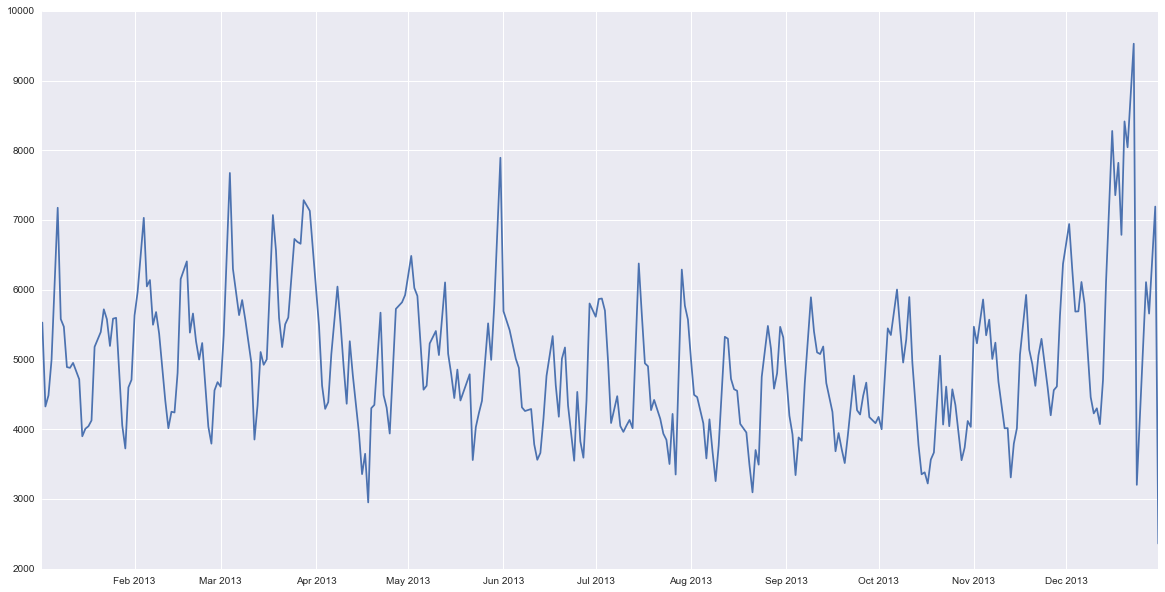

In [109]:
# criteria = dtrain[(dtrain['Store']==1) & (dtrain['Date']<datetime.date(2014,1,1))]
criteria = dtrain[(dtrain['Store']==1) & (dtrain['Sales']>0) & (dtrain['Date']<datetime.date(2014,1,1))].copy()
# criteria = dtrain[dtrain['Store']==1]
plt.figure(figsize=(20,10))
plt.plot(criteria['Date'].values,criteria['Sales'].values)
# d = criteria['Date']
# s = criteria['Sales']
# plt.plot(d,s)

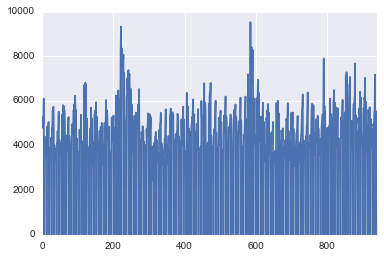

In [81]:
# Visualize
dtrain.set_index(pd.DatetimeIndex(dtrain['Date']))
dtest.set_index(pd.DatetimeIndex(dtrain['Date']))
sb.tsplot(criteria)